In [33]:
import argparse
import logging.config
import os
from collections import defaultdict

from dotenv import load_dotenv

from rescueclip.logging_config import LOGGING_CONFIG

logging.config.dictConfig(LOGGING_CONFIG)
logger = logging.getLogger(__name__)
from pathlib import Path

import numpy as np
from typing import cast, Sequence, Literal
import weaviate
from tqdm import tqdm
from weaviate.classes.query import Filter, MetadataQuery
from weaviate.util import generate_uuid5, get_vector

from rescueclip import cuhk
from rescueclip.ml_model import (
    CollectionConfig,
    encode_image,
    CUHK_Apple_Collection,
    CUHK_Google_Siglip_Base_Patch16_224_Collection,
    CUHK_Google_Siglip_SO400M_Patch14_384_Collection,
    CUHK_laion_CLIP_ViT_bigG_14_laion2B_39B_b160k_Collection,
    CUHK_MetaCLIP_ViT_bigG_14_quickgelu_224_Collection,
    CUHK_ViT_B_32_Collection,
)
from rescueclip.weaviate import WeaviateClientEnsureReady

from pprint import pprint

from embed_cuhk import Metadata, embed_cuhk_dataset

load_dotenv()
QUERY_MAXIMUM_RESULTS = 200_000

INPUT_FOLDER = Path(os.environ["CUHK_PEDES_DATASET"]) / "out"
STOPS_FILE = Path("/scratch3/gbiss/images/CUHK-PEDES-OFFICIAL/caption_all.json")
sets = cuhk.get_sets_new(INPUT_FOLDER, STOPS_FILE)
sets = cuhk.keep_sets_containing_n_images(sets, 4)
number_of_images_in_sets = cuhk.get_number_of_images_in_sets(sets)

%load_ext autoreload
%autoreload 2

2025-02-22 11:18:27,967 [INFO] rescueclip.cuhk: After filtering, using 4649 sets and 18596 images
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
client = WeaviateClientEnsureReady().get_client()

2025-02-22 11:18:28,118 [INFO] rescueclip.weaviate: Weaviate is ready


/scratch3/atharva/anaconda3/envs/rescueCLIP/lib/python3.12/site-packages/weaviate/warnings.py:314: ResourceWarning: Con004: The connection to Weaviate was not closed properly. This can lead to memory leaks.
            Please make sure to close the connection using `client.close()`.
  warnings.warn(


In [35]:
from scipy.spatial.distance import pdist
import math

type SetMetrics = dict[int, tuple[np.floating, np.floating]]

def get_set_metrics_for_collection_config(collection_config: CollectionConfig, sets: cuhk.SetNumToImagesMap, number_of_images_in_sets: int, distance_metric: Literal["cosine"]) -> SetMetrics:
    collection = client.collections.get(collection_config.name)
    number_of_objects: int = collection.aggregate.over_all(total_count=True).total_count # type: ignore
    logger.info(f"Number of objects %s", number_of_objects)
    assert (
        number_of_objects <= QUERY_MAXIMUM_RESULTS 
    ), "Ensure docker-compose.yml has QUERY_MAXIMUM_RESULTS to greater than 200_000 or the experiment's results may be inaccurate"
    assert number_of_images_in_sets == number_of_objects, f"Number of images in sets is {cuhk.get_number_of_images_in_sets(sets)}, but should be {number_of_objects}"

    set_to_metrics: SetMetrics = {}
    for sett in tqdm(sets, desc=collection_config.name):
        images = sets[sett]
        images = collection.query.fetch_objects(
            filters=Filter.by_property("set_number").equal(sett),
            include_vector=True,
        ).objects
        assert len(images) == len(sets[sett]) == 4, f"Expected {len(sets[sett])} images but got {len(images)}"
        image_vectors = [image.vector["embedding"] for image in images]
        X = np.array(image_vectors)
        assert X.shape[0] == 4, f"Expected 4 rows but got {X.shape[0]}"
        
        if distance_metric == "cosine":
            # Compute cosine distances
            distances = pdist(X, metric='cosine')

            # Normalize distances
            distances /=  2     # move the range of distances from [0, 2] to [0, 1]

        else:
            raise ValueError(f"Invalid distance metric {distance_metric}")
        
        
        assert distances.shape[0] == math.comb(len(sets[sett]), 2), f"Expected {math.comb(len(sets[sett]), 2)} distances but got {distances.shape[0]}"

        avg = np.mean(distances)
        std = np.std(distances)

        assert not np.isnan(avg), f"Average is NaN for {sett}"
        assert not np.isnan(std), f"Std is NaN for {sett}"

        set_to_metrics[sett] = (avg, std)
    
    return set_to_metrics


In [36]:
def get_set_metrics_for_pdna(
    sets: cuhk.SetNumToImagesMap,
    number_of_images_in_sets: int,
    distance_metric: Literal["cosine"] | Literal["euclidean"],
) -> SetMetrics:
    hashes_file = Path("/scratch3/atharva/photodna/hashes.csv")
    set_lookup_map = {
        filename: set_id for set_id, file_list in sets.items() for filename in file_list
    }

    # Get the PDNA hashes
    filename_to_hash_map, missing_filenames = cuhk.get_pdna_hashes(
        hashes_file, include_only=set(set_lookup_map.keys())
    )
    sets = cuhk.eliminate_sets_containing_files(filename_to_hash_map, missing_filenames, sets)
    set_lookup_map = {
        filename: set_id for set_id, file_list in sets.items() for filename in file_list
    }

    assert len(filename_to_hash_map) == len(
        set_lookup_map
    ), f"Some images are missing hashes, {len(filename_to_hash_map)} != {len(set_lookup_map)}"
    logger.info(f"Loaded {len(filename_to_hash_map)} hashes")

    set_to_metrics: SetMetrics = {}
    for sett in tqdm(sets, desc="PDNA"):
        file_names = sets[sett]
        image_vectors = [filename_to_hash_map[file_name] for file_name in file_names]
        X = np.array(image_vectors)
        assert X.shape[0] == 4, f"Expected 4 rows but got {X.shape[0]}"
        assert X.shape[1] == 144, f"Expected 144 cols but got {X.shape[1]}"

        # Normalize the vectors

        if distance_metric == "cosine":
            X = X / np.linalg.norm(X, axis=1, keepdims=True)
            distances = pdist(X, metric="cosine")
            distances /= 2  # Normalize by the number of vectors to cut the range to [0, 1]
        elif distance_metric == "euclidean":
            distances = pdist(X, metric="euclidean")
            # Normalize by the number of vectors to cut the range to [0, 1]
            distances = distances / np.sqrt(144 * 255 ** 2)
        else:
            raise ValueError(f"Invalid distance_metric={distance_metric}")

        assert distances.shape[0] == math.comb(
            len(sets[sett]), 2
        ), f"Expected {math.comb(len(sets[sett]), 2)} distances but got {distances.shape[0]}"

        avg = np.mean(distances)
        std = np.std(distances)

        assert not np.isnan(avg), f"Average is NaN for {sett=}"
        assert not np.isnan(std), f"Std is NaN for {sett=}"

        set_to_metrics[sett] = (avg, std)

    return set_to_metrics

In [37]:
collection_configs = [CUHK_Apple_Collection, CUHK_ViT_B_32_Collection]

all_data: dict[str, SetMetrics] = {}

clip_distance_function = 'cosine'

for collection_config in collection_configs:
    set_to_metrics = get_set_metrics_for_collection_config(collection_config, sets, number_of_images_in_sets, clip_distance_function)
    all_data[collection_config.model_config.model_name + f' ({clip_distance_function})'] = set_to_metrics

2025-02-22 11:18:28,244 [INFO] __main__: Number of objects 18596


Apple_DFN5B_CLIP_ViT_H_14_384_CUHK:   0%|          | 0/4649 [00:00<?, ?it/s]

Apple_DFN5B_CLIP_ViT_H_14_384_CUHK: 100%|██████████| 4649/4649 [00:15<00:00, 295.36it/s]

2025-02-22 11:18:44,003 [INFO] __main__: Number of objects 18596



ViT_B_32_CUHK: 100%|██████████| 4649/4649 [00:13<00:00, 347.44it/s]


In [42]:
# PDNA
pdna_distance_function = 'cosine'
all_data[f'PhotoDNA ({pdna_distance_function})'] = get_set_metrics_for_pdna(sets, number_of_images_in_sets, pdna_distance_function)

2025-02-22 11:20:36,879 [INFO] __main__: Loaded 17224 hashes


PDNA: 100%|██████████| 4306/4306 [00:00<00:00, 21687.47it/s]


2025-02-22 11:21:32,862 [INFO] __main__: Plotting 3 models
2025-02-22 11:21:32,875 [INFO] __main__: Series mean: 0.07698385399280967
2025-02-22 11:21:32,882 [INFO] __main__: Series mean: 0.11391171703736667
2025-02-22 11:21:32,886 [INFO] __main__: Series mean: 0.14324323265568256


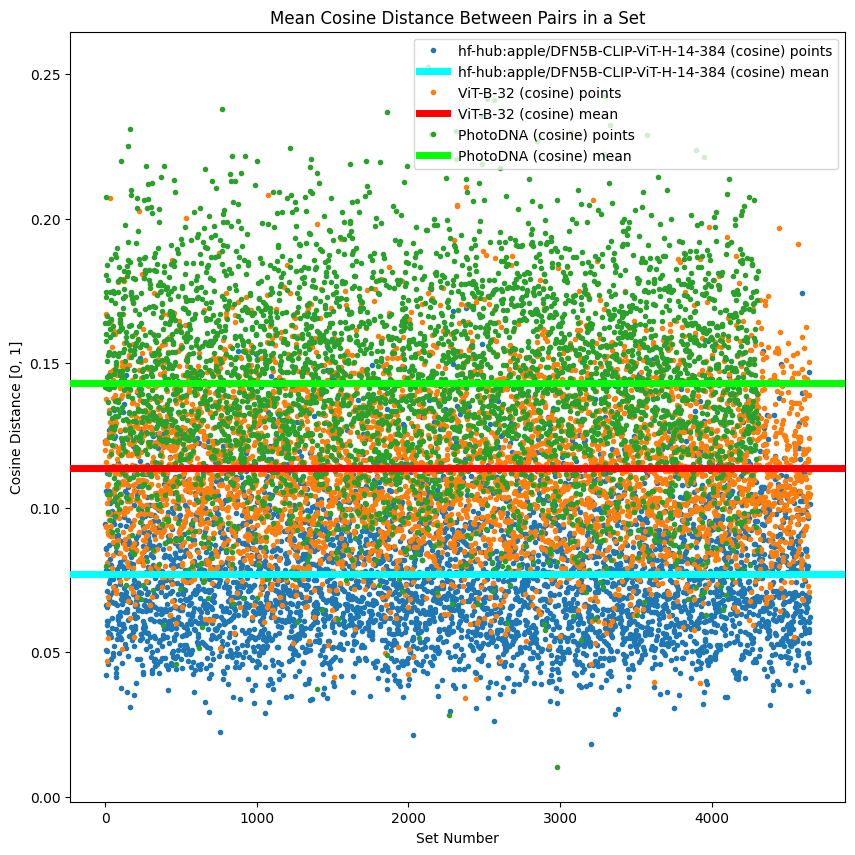

"\nHere's another (cool?) graph that computes the mean cosine distance between all pairs within a set, plots each set number on the x-axis, and plots those means on the y-axis (y-axis range is [0, 2]). The horizontal line for each model is the overall mean across all that model's points.\n\nWe can see the clear separation between two CLIP models (how they compare in the cosine distance between images within the same set)\n"

In [49]:
import matplotlib.pyplot as plt

# Choose a colormap to get distinct colors
num_plots = len(all_data)
logger.info(f"Plotting {num_plots} models")
colors = plt.get_cmap("tab10")  # Use a distinct color map
line_colors = ["cyan", "red", "lime", "purple"]  # Pick distinct colors


# Create the plot
plt.figure(figsize=(10, 10))
for i, (model_name, set_to_metrics) in enumerate(all_data.items()):
    x = np.arange(len(set_to_metrics))
    y = np.array([set_to_metrics[k][0] for k in set_to_metrics])
    y_err = np.array([set_to_metrics[k][1] for k in set_to_metrics])

    # Assign a distinct color from tab10
    dot_color = colors(i)

    # Plot the means as small dots.
    plt.plot(x, y, 'o', markersize=3, color=dot_color, label=f'{model_name} points', zorder=2)

    # Compute the overall mean for this series.
    series_mean = np.mean(y)

    logger.info(f"Series mean: {series_mean}")

    line_color = line_colors[i % len(line_colors)]

    # Plot a horizontal dashed line across the x-axis for this series mean.
    plt.axhline(
        y=float(series_mean),
        color=line_color,
        linestyle="-",
        linewidth=5,
        label=f"{model_name} mean",
        zorder=3,
    )


# Create an errorbar plot
plt.xlabel("Set Number")
if clip_distance_function == pdna_distance_function == 'cosine':
    plt.ylabel("Cosine Distance [0, 1]")
else:
    plt.ylabel("Distance [0, 1]")

plt.title("Mean Cosine Distance Between Pairs in a Set")
# plt.ylim(0, 2)  # Set y-axis limits between 0 and 2
plt.legend()
plt.show()

"""
Here's another (cool?) graph that computes the mean cosine distance between all pairs within a set, plots each set number on the x-axis, and plots those means on the y-axis (y-axis range is [0, 2]). The horizontal line for each model is the overall mean across all that model's points.

We can see the clear separation between two CLIP models (how they compare in the cosine distance between images within the same set)
"""

2025-02-22 11:21:33,156 [INFO] __main__: Plotting 3 models
2025-02-22 11:21:33,161 [INFO] __main__: Series mean: 0.07698385399280967
2025-02-22 11:21:33,172 [INFO] __main__: Series mean: 0.11391171703736667
2025-02-22 11:21:33,178 [INFO] __main__: Series mean: 0.14324323265568256


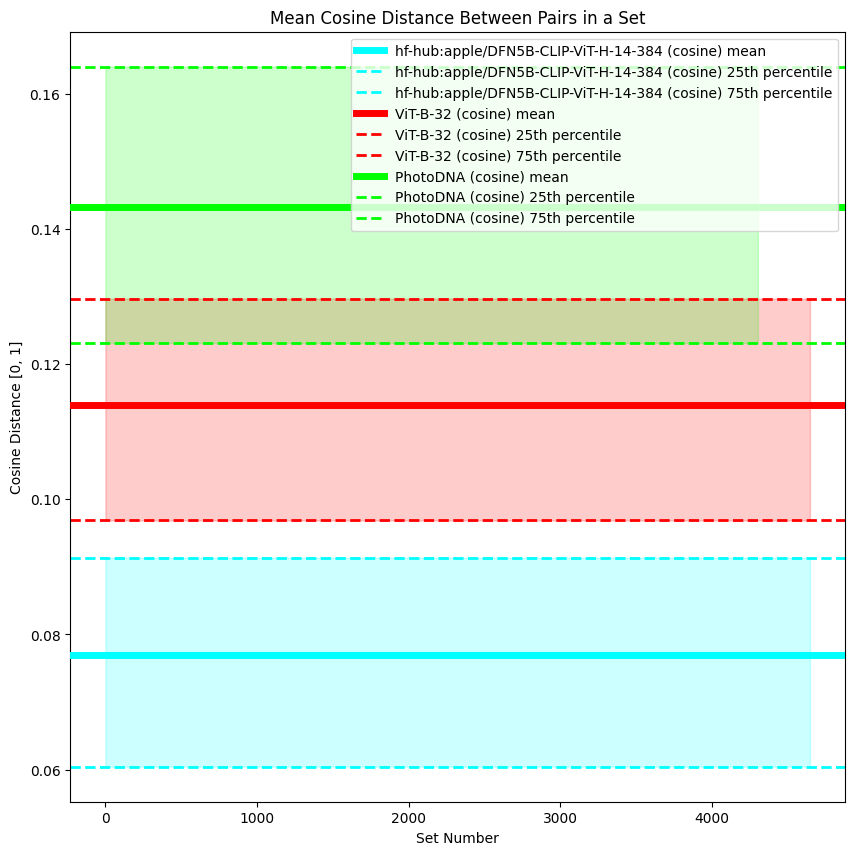

"\nHere's another (cool?) graph that computes the mean cosine distance between all pairs within a set, plots each set number on the x-axis, and plots those means on the y-axis (y-axis range is [0, 2]). The horizontal line for each model is the overall mean across all that model's points.\n\nWe can see the clear separation between two CLIP models (how they compare in the cosine distance between images within the same set)\n"

In [50]:
import matplotlib.pyplot as plt

# Choose a colormap to get distinct colors
num_plots = len(all_data)
logger.info(f"Plotting {num_plots} models")
colors = plt.get_cmap("tab10")  # Use a distinct color map
line_colors = ["cyan", "red", "lime", "purple"]  # Pick distinct colors


# Create the plot
plt.figure(figsize=(10, 10))
for i, (model_name, set_to_metrics) in enumerate(all_data.items()):
    x = np.arange(len(set_to_metrics))
    y = np.array([set_to_metrics[k][0] for k in set_to_metrics])
    y_err = np.array([set_to_metrics[k][1] for k in set_to_metrics])

    # Assign a distinct color from tab10
    dot_color = colors(i)

    # Plot the means as small dots.
    # plt.plot(x, y, 'o', markersize=3, color=dot_color, label=f'{model_name} points', zorder=2)

    # Compute the overall mean for this series.
    series_mean = np.mean(y)

    logger.info(f"Series mean: {series_mean}")

    line_color = line_colors[i % len(line_colors)]

    # Plot a horizontal dashed line across the x-axis for this series mean.
    plt.axhline(
        y=float(series_mean),
        color=line_color,
        linestyle="-",
        linewidth=5,
        label=f"{model_name} mean",
        zorder=3,
    )

    # Plot the 25th and 75th percentile bands as dashed lines
    # Compute percentiles
    y_10 = float(np.percentile(y, 25))  # 25th percentile
    y_90 = float(np.percentile(y, 75))  # 75th percentile
    plt.axhline(
        y=y_10,
        color=line_color,
        linestyle="dashed",
        linewidth=2,
        label=f"{model_name} 25th percentile",
        zorder=2,
    )
    plt.axhline(
        y=y_90,
        color=line_color,
        linestyle="dashed",
        linewidth=2,
        label=f"{model_name} 75th percentile",
        zorder=2,
    )
    plt.fill_between(x, y_10, y_90, color=line_color, alpha=0.2, zorder=1)


# Create an errorbar plot
plt.xlabel("Set Number")
if clip_distance_function == pdna_distance_function == 'cosine':
    plt.ylabel("Cosine Distance [0, 1]")
else:
    plt.ylabel("Distance [0, 1]")
plt.title("Mean Cosine Distance Between Pairs in a Set")
# plt.ylim(0, 2)  # Set y-axis limits between 0 and 2
plt.legend()
plt.show()

"""
Here's another (cool?) graph that computes the mean cosine distance between all pairs within a set, plots each set number on the x-axis, and plots those means on the y-axis (y-axis range is [0, 2]). The horizontal line for each model is the overall mean across all that model's points.

We can see the clear separation between two CLIP models (how they compare in the cosine distance between images within the same set)
"""

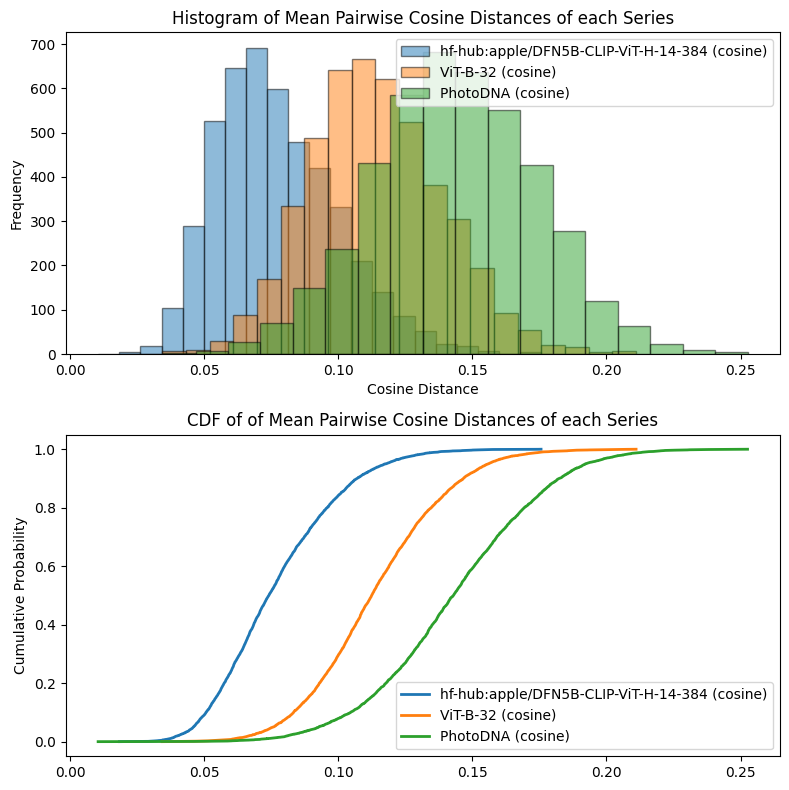

In [51]:
# Prepare a figure with two subplots: top=Histogram, bottom=CDF
fig, (ax_hist, ax_cdf) = plt.subplots(nrows=2, ncols=1, figsize=(8, 8), sharex=False)

# Generate a color cycle or pick your own colors
colors = plt.get_cmap('tab10')  # or use e.g. ['blue', 'orange', 'green', ...]

for i, (model_name, set_to_metrics) in enumerate(all_data.items()):
    # Extract the values (first element of each tuple)
    values = np.array([v[0] for v in set_to_metrics.values()])
    
    # 1) Plot the Histogram on the top subplot
    ax_hist.hist(
        values,
        bins=20,            # You can adjust the number of bins
        alpha=0.5,          # Transparency
        label=model_name,
        color=colors(i),
        edgecolor='black'
    )
    
    # 2) Compute and plot the CDF on the bottom subplot
    sorted_vals = np.sort(values)
    cdf_vals = np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)
    
    ax_cdf.plot(
        sorted_vals,
        cdf_vals,
        label=model_name,
        color=colors(i),
        linewidth=2
    )

# Configure histogram axis
ax_hist.set_title("Histogram of Mean Pairwise Cosine Distances of each Series")
ax_hist.set_xlabel("Cosine Distance")
ax_hist.set_ylabel("Frequency")
ax_hist.legend()

# Configure CDF axis
ax_cdf.set_title("CDF of of Mean Pairwise Cosine Distances of each Series")
if clip_distance_function == pdna_distance_function == 'cosine':
    plt.ylabel("Cosine Distance [0, 1]")
else:
    plt.ylabel("Distance [0, 1]")
ax_cdf.set_ylabel("Cumulative Probability")
ax_cdf.legend()

plt.tight_layout()
plt.show()